In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings("ignore")

In [2]:
# 1 Load Cleaned Dataset

df = pd.read_csv("Dataset/Cleaned.csv")

X = df.drop(columns=["NSP", "CLASS"])
y = df["CLASS"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

X_train.shape, X_test.shape

((1700, 21), (426, 21))

In [3]:
# 2 This Wrapper for XGB is important as it maps the labels from 1,2,3,4,5,.... to 0,1,2,3,4,....

class XGBWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, **kwargs):
        self.model = XGBClassifier(**kwargs)
        self.class_map = None
        self.inv_map = None

    def fit(self, X, y):
        unique = np.unique(y)
        self.class_map = {c: i for i, c in enumerate(unique)}
        self.inv_map = {i: c for c, i in self.class_map.items()}
        
        y_mapped = np.array([self.class_map[c] for c in y])
        
        self.model.fit(X, y_mapped)
        return self

    def predict(self, X):
        preds = self.model.predict(X)
        return np.array([self.inv_map[p] for p in preds])

    def predict_proba(self, X):
        proba = self.model.predict_proba(X)
        return proba

In [4]:
# 3 Model Evaluation and Confusion Matrix Plotter

def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    acc = accuracy_score(y_test, preds)
    macro_f1 = f1_score(y_test, preds, average='macro')

    print(f"\n==== {name} ====")
    print("Accuracy:", round(acc, 4))
    print("Macro F1:", round(macro_f1, 4))
    
    print("\nClassification Report:")
    print(classification_report(y_test, preds))

    labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    cm = confusion_matrix(y_test, preds, labels=labels)
    sns.heatmap(cm, annot=True, cmap="Blues", fmt="g", xticklabels=labels, yticklabels=labels)
    plt.title(f"{name} - Confusion Matrix")
    plt.show()

    return {"model": name, "accuracy": acc, "macro_f1": macro_f1}

In [5]:
# 4 Model Sweep

models = {

    # Linear Models
    "Logistic Regression": LogisticRegression(max_iter=500, multi_class="multinomial"),
    "Linear SVM": SVC(kernel="linear"), 

    # Tree Ensembles
    "Random Forest": RandomForestClassifier(n_estimators=300, random_state=42),
    "Extra Trees": ExtraTreesClassifier(n_estimators=300, random_state=42),

    # Gradient Boosting
    "LightGBM": LGBMClassifier(random_state=42, class_weight="balanced"),
    "XGBoost": XGBWrapper(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="mlogloss",
        random_state=42,
        objective="multi:softprob"
    ),

    "CatBoost": CatBoostClassifier(
        iterations=300, learning_rate=0.05,
        depth=6, loss_function="MultiClass",
        verbose=0, random_state=42
    ),

    # Probabilistic / Distance
    "kNN": KNeighborsClassifier(n_neighbors=7),
    "Naive Bayes": GaussianNB(),

    # Neural Network
    "MLP": MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
}


==== Logistic Regression ====
Accuracy: 0.8075
Macro F1: 0.7192

Classification Report:
              precision    recall  f1-score   support

         1.0       0.72      0.79      0.75        77
         2.0       0.90      0.92      0.91       116
         3.0       0.38      0.27      0.32        11
         4.0       0.85      0.69      0.76        16
         5.0       0.73      0.57      0.64        14
         6.0       0.97      0.87      0.91        67
         7.0       0.90      0.86      0.88        51
         8.0       0.80      0.95      0.87        21
         9.0       0.47      0.64      0.55        14
        10.0       0.62      0.59      0.61        39

    accuracy                           0.81       426
   macro avg       0.73      0.72      0.72       426
weighted avg       0.81      0.81      0.81       426



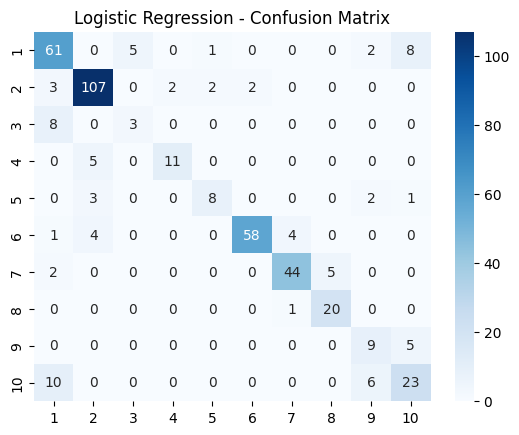


==== Linear SVM ====
Accuracy: 0.8427
Macro F1: 0.7553

Classification Report:
              precision    recall  f1-score   support

         1.0       0.79      0.86      0.82        77
         2.0       0.89      0.92      0.91       116
         3.0       0.20      0.09      0.12        11
         4.0       0.86      0.75      0.80        16
         5.0       0.90      0.64      0.75        14
         6.0       0.98      0.85      0.91        67
         7.0       0.88      0.86      0.87        51
         8.0       0.87      0.95      0.91        21
         9.0       0.61      0.79      0.69        14
        10.0       0.73      0.82      0.77        39

    accuracy                           0.84       426
   macro avg       0.77      0.75      0.76       426
weighted avg       0.84      0.84      0.84       426



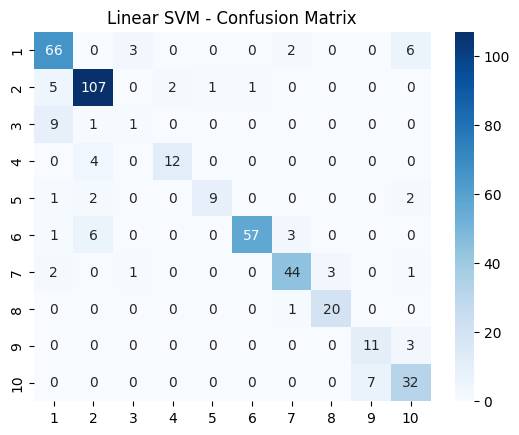


==== Random Forest ====
Accuracy: 0.8967
Macro F1: 0.8296

Classification Report:
              precision    recall  f1-score   support

         1.0       0.89      0.95      0.92        77
         2.0       0.87      0.96      0.91       116
         3.0       1.00      0.45      0.62        11
         4.0       0.89      0.50      0.64        16
         5.0       0.75      0.43      0.55        14
         6.0       0.97      0.88      0.92        67
         7.0       0.94      0.98      0.96        51
         8.0       0.95      1.00      0.98        21
         9.0       0.88      1.00      0.93        14
        10.0       0.83      0.90      0.86        39

    accuracy                           0.90       426
   macro avg       0.90      0.80      0.83       426
weighted avg       0.90      0.90      0.89       426



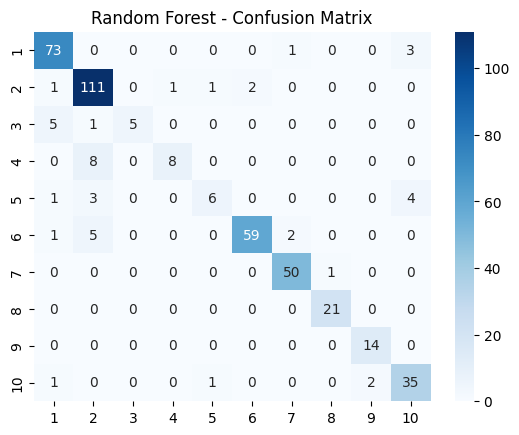


==== Extra Trees ====
Accuracy: 0.8803
Macro F1: 0.8012

Classification Report:
              precision    recall  f1-score   support

         1.0       0.82      0.94      0.87        77
         2.0       0.88      0.97      0.92       116
         3.0       0.75      0.27      0.40        11
         4.0       1.00      0.56      0.72        16
         5.0       0.88      0.50      0.64        14
         6.0       0.95      0.87      0.91        67
         7.0       0.92      0.92      0.92        51
         8.0       0.91      0.95      0.93        21
         9.0       0.80      0.86      0.83        14
        10.0       0.85      0.90      0.88        39

    accuracy                           0.88       426
   macro avg       0.88      0.77      0.80       426
weighted avg       0.88      0.88      0.87       426



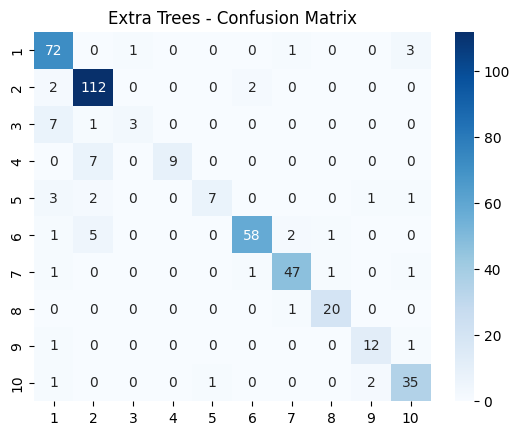

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000177 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1207
[LightGBM] [Info] Number of data points in the train set: 1700, number of used features: 20
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

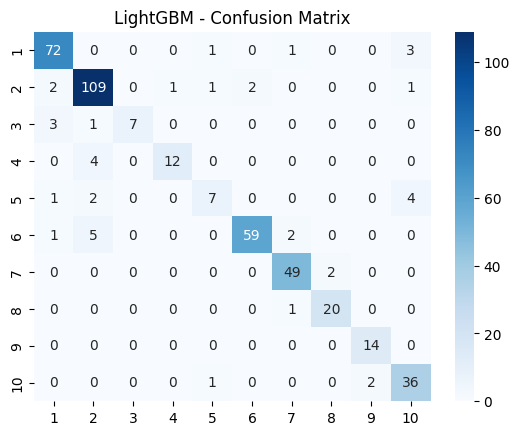


==== XGBoost ====
Accuracy: 0.9014
Macro F1: 0.8404

Classification Report:
              precision    recall  f1-score   support

         1.0       0.89      0.95      0.92        77
         2.0       0.88      0.97      0.92       116
         3.0       1.00      0.55      0.71        11
         4.0       1.00      0.62      0.77        16
         5.0       0.71      0.36      0.48        14
         6.0       0.97      0.90      0.93        67
         7.0       0.94      0.94      0.94        51
         8.0       0.91      0.95      0.93        21
         9.0       0.88      1.00      0.93        14
        10.0       0.84      0.92      0.88        39

    accuracy                           0.90       426
   macro avg       0.90      0.82      0.84       426
weighted avg       0.90      0.90      0.90       426



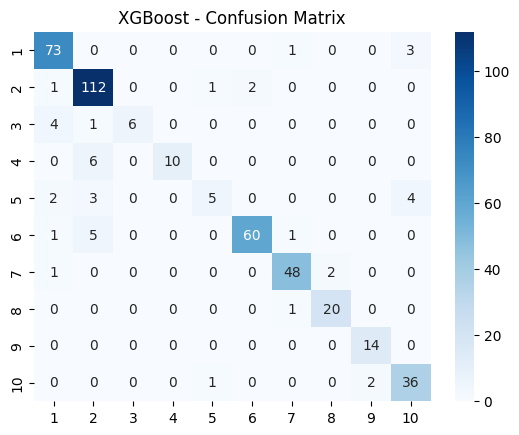


==== CatBoost ====
Accuracy: 0.8944
Macro F1: 0.8349

Classification Report:
              precision    recall  f1-score   support

         1.0       0.87      0.94      0.90        77
         2.0       0.87      0.95      0.91       116
         3.0       1.00      0.55      0.71        11
         4.0       0.89      0.50      0.64        16
         5.0       0.83      0.36      0.50        14
         6.0       0.97      0.88      0.92        67
         7.0       0.94      0.96      0.95        51
         8.0       0.91      0.95      0.93        21
         9.0       1.00      1.00      1.00        14
        10.0       0.83      0.97      0.89        39

    accuracy                           0.89       426
   macro avg       0.91      0.81      0.83       426
weighted avg       0.90      0.89      0.89       426



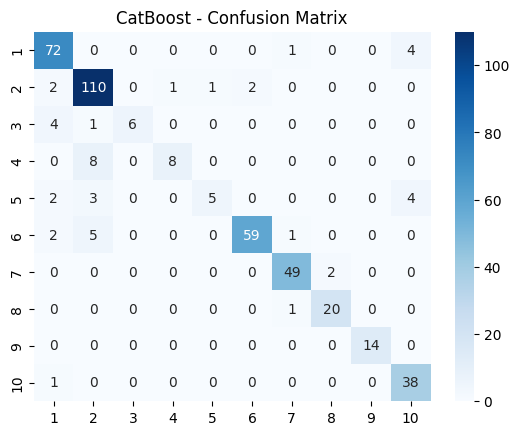


==== kNN ====
Accuracy: 0.7066
Macro F1: 0.5973

Classification Report:
              precision    recall  f1-score   support

         1.0       0.60      0.79      0.68        77
         2.0       0.75      0.81      0.78       116
         3.0       0.00      0.00      0.00        11
         4.0       0.55      0.38      0.44        16
         5.0       0.40      0.14      0.21        14
         6.0       0.71      0.73      0.72        67
         7.0       0.73      0.63      0.67        51
         8.0       0.87      0.95      0.91        21
         9.0       1.00      0.71      0.83        14
        10.0       0.75      0.69      0.72        39

    accuracy                           0.71       426
   macro avg       0.64      0.58      0.60       426
weighted avg       0.69      0.71      0.69       426



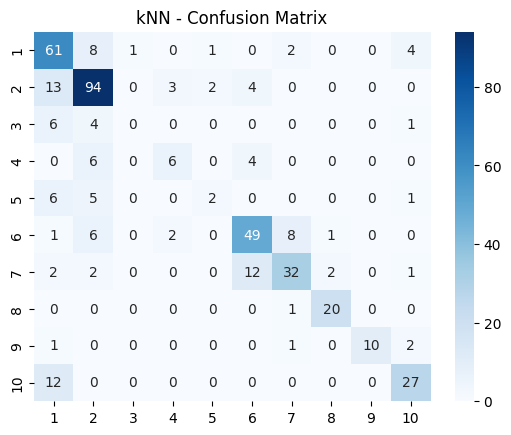


==== Naive Bayes ====
Accuracy: 0.615
Macro F1: 0.585

Classification Report:
              precision    recall  f1-score   support

         1.0       0.70      0.52      0.60        77
         2.0       0.73      0.50      0.59       116
         3.0       0.30      0.55      0.39        11
         4.0       0.28      1.00      0.44        16
         5.0       0.33      0.64      0.44        14
         6.0       0.92      0.72      0.81        67
         7.0       0.93      0.76      0.84        51
         8.0       0.83      0.95      0.89        21
         9.0       0.29      0.86      0.43        14
        10.0       0.54      0.36      0.43        39

    accuracy                           0.62       426
   macro avg       0.59      0.69      0.59       426
weighted avg       0.71      0.62      0.64       426



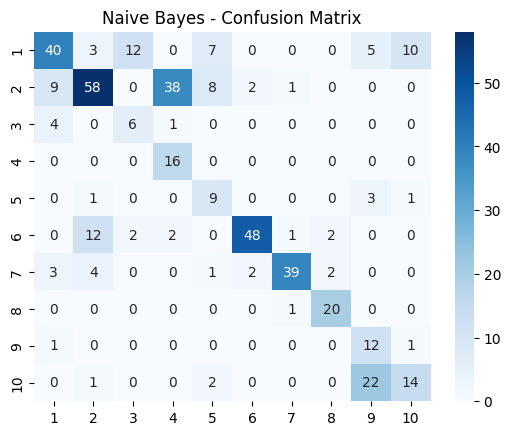


==== MLP ====
Accuracy: 0.8122
Macro F1: 0.685

Classification Report:
              precision    recall  f1-score   support

         1.0       0.74      0.94      0.83        77
         2.0       0.82      0.97      0.89       116
         3.0       0.17      0.09      0.12        11
         4.0       0.86      0.38      0.52        16
         5.0       1.00      0.29      0.44        14
         6.0       0.98      0.73      0.84        67
         7.0       0.85      0.86      0.85        51
         8.0       0.83      0.95      0.89        21
         9.0       0.59      0.93      0.72        14
        10.0       0.89      0.64      0.75        39

    accuracy                           0.81       426
   macro avg       0.77      0.68      0.68       426
weighted avg       0.83      0.81      0.80       426



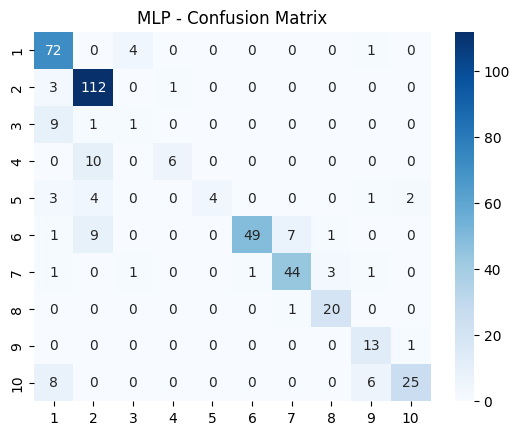

In [6]:
# 5 Store Results

results = []

for name, model in models.items():
    res = evaluate_model(name, model, X_train, y_train, X_test, y_test)
    results.append(res)

In [7]:
# 6 Rank Models

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="macro_f1", ascending=False)

results_df

,model,accuracy,macro_f1
4,LightGBM,0.903756,0.862682
5,XGBoost,0.901408,0.840438
6,CatBoost,0.894366,0.834891
2,Random Forest,0.896714,0.829622
3,Extra Trees,0.880282,0.801154
1,Linear SVM,0.842723,0.755262
0,Logistic Regression,0.807512,0.719180
9,MLP,0.812207,0.684966
7,kNN,0.706573,0.597331
8,Naive Bayes,0.615023,0.585003


In [8]:
# 7 Top 3 Models

print("Top 3 Models by Macro F1:\n")
print(results_df.head(3))   

Top 3 Models by Macro F1:

      model  accuracy  macro_f1
4  LightGBM  0.903756  0.862682
5   XGBoost  0.901408  0.840438
6  CatBoost  0.894366  0.834891
